In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
from pathlib import Path
from datetime import datetime

from noise import *
from utils import datetime_from_filename, get_data_files, run_multiprocessing, weather_from_time, weather_sum
from counter_config import *

In [2]:
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin','rutherford','wu','einstein','yukawa','dirac','meitner']
niche_data_dir = Path('/home/isaac/niche_data/')

In [3]:
cfgs = []
times = []
for datepath in niche_data_dir.iterdir():
    alldata = get_data_files(datepath.name)
    datatimes = list(set([f.name[:-4] for f in alldata if f.name.endswith('.bin') and f.name[-5].isnumeric()]))
    cfgs.extend([init_config(t) for t in datatimes])
    times.extend([datetime.strptime(t, '%Y%m%d%H%M%S') for t in datatimes])

In [4]:
weather_codes = run_multiprocessing(weather_from_time,times)

|████████████████████████████████████████| 2300/2300 [100%] in 0.3s (7029.83/s) 


In [5]:
pts = run_multiprocessing(pt,cfgs,chunksize=1)

|████████████████████████████████████████| 2300/2300 [100%] in 3:00.7 (12.73/s) 


In [6]:
gains = run_multiprocessing(estimate_gain,cfgs,chunksize=1)

|████████████████████████████████████████| 2300/2300 [100%] in 56:02.6 (0.68/s) 


In [7]:
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin','rutherford','einstein','meitner']

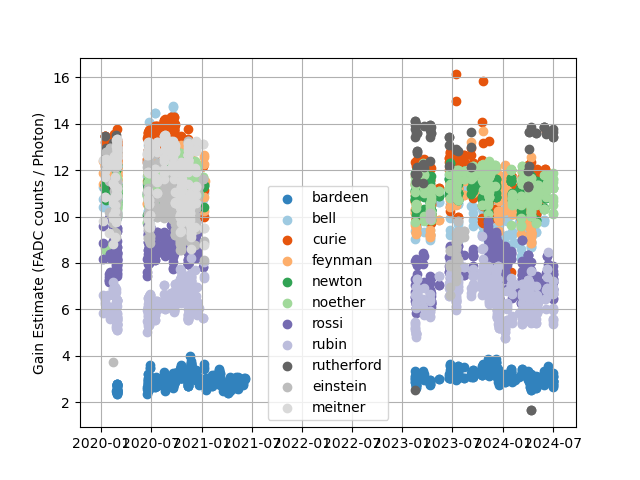

In [14]:
c = np.arange(len(counters))
colors = plt.cm.tab20c(c/c.max())
plt.figure()
for i,counter in enumerate(counters):
    tls = [(t,l) for t,l,w in zip(times,gains,weather_codes) if counter in l and w=='0000000']
    ts = np.array([tl[0] for tl in tls])
    ls = np.array([tl[1][counter] for tl in tls])
    plt.scatter(ts, ls, color = colors[i], label = counter)
plt.legend()
plt.ylabel('Gain Estimate (FADC counts / Photon)')
plt.grid()

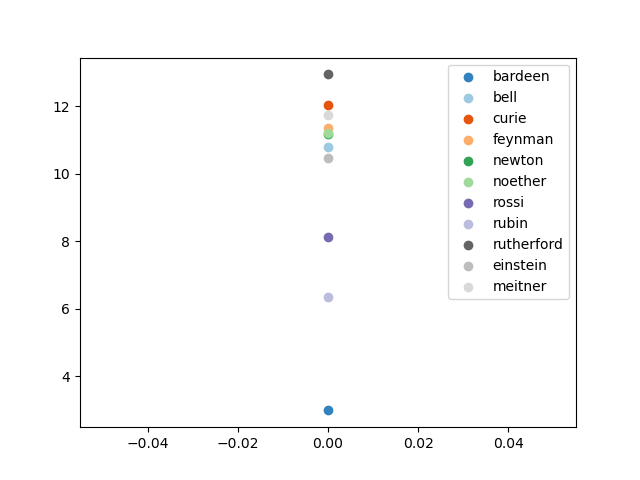

In [9]:
plt.figure()
for i,counter in enumerate(counters):
    levels = np.array([l[counter] for l in gains if counter in l])
    avg_level = levels[~np.isnan(levels)].mean()
    plt.scatter(0,avg_level,label=counter, color = colors[i])
plt.legend()

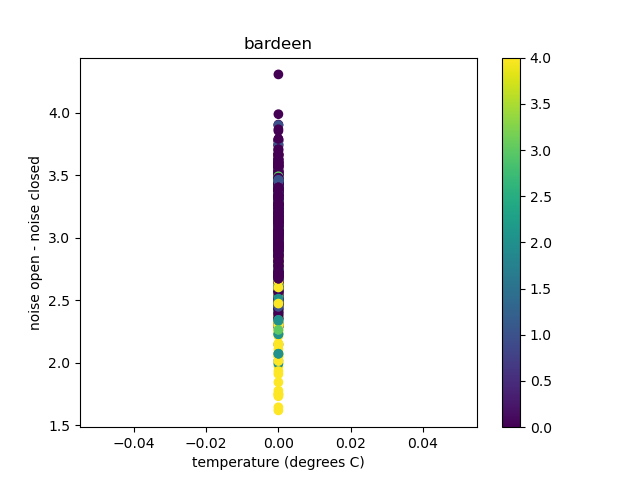

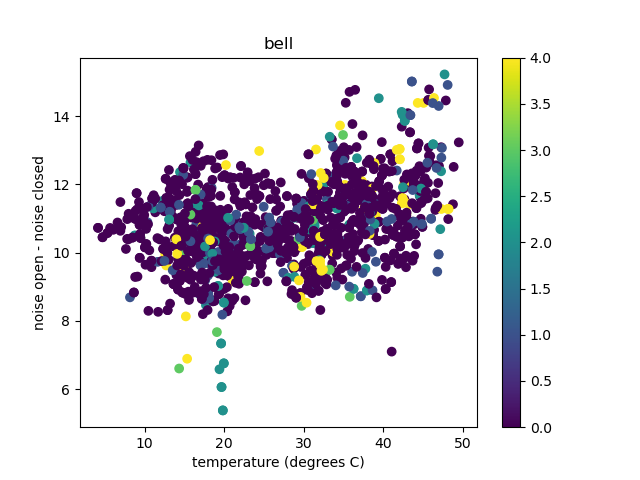

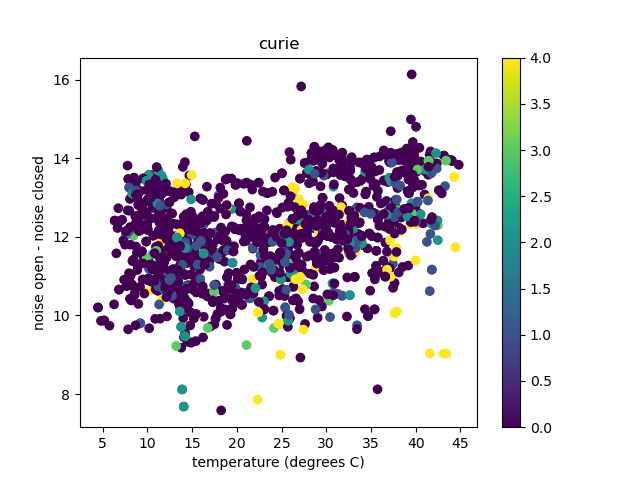

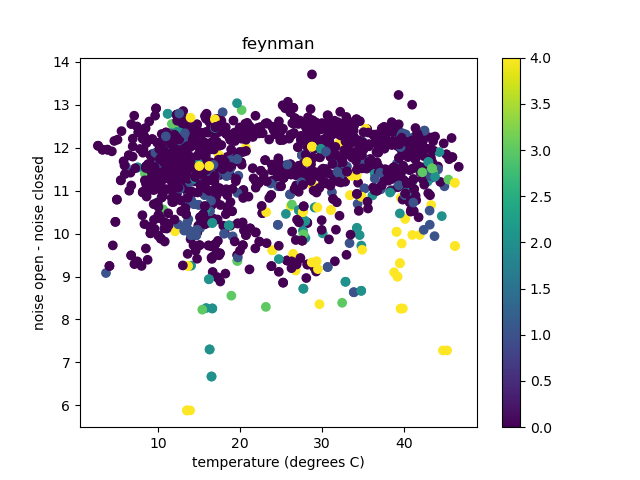

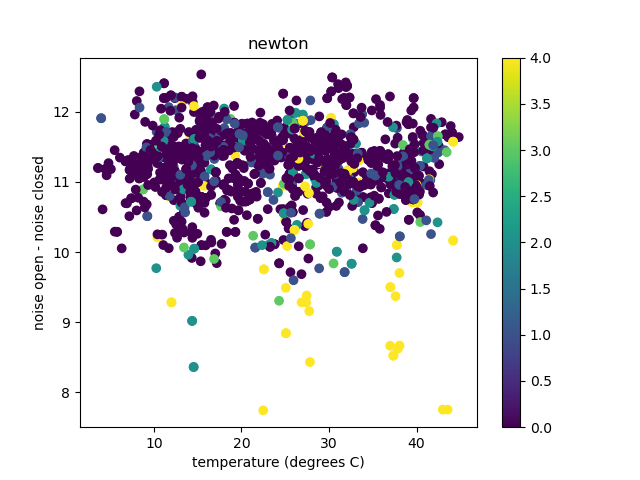

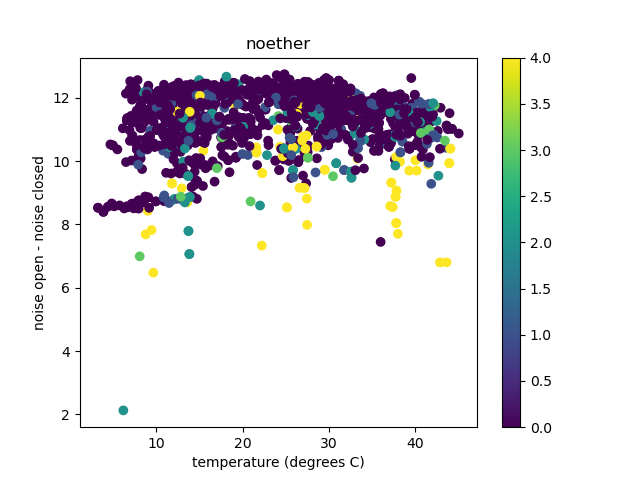

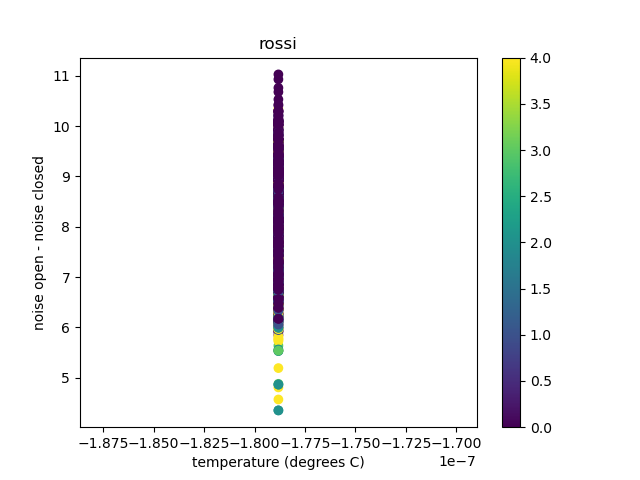

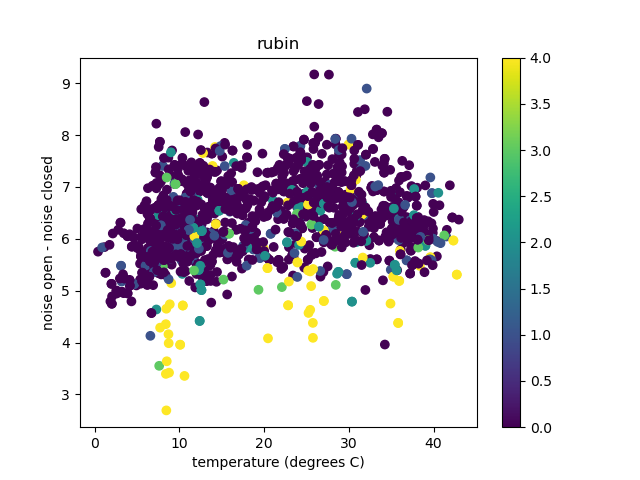

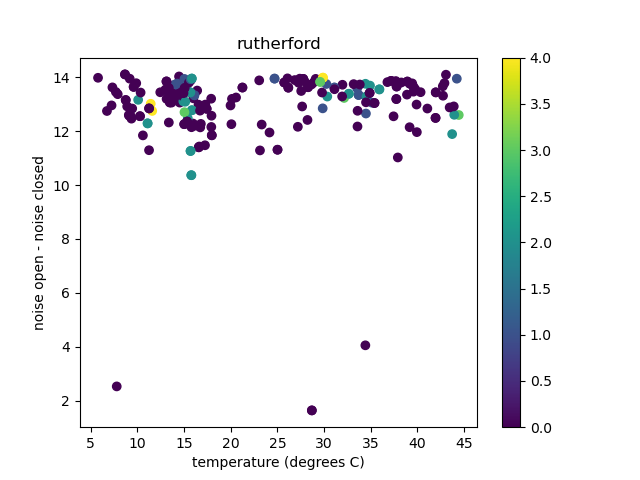

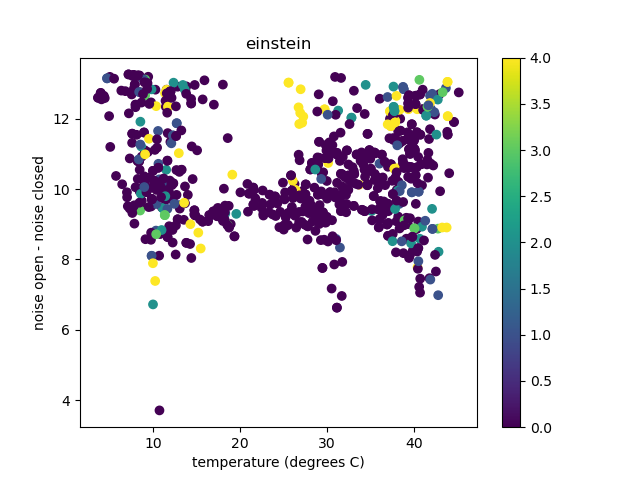

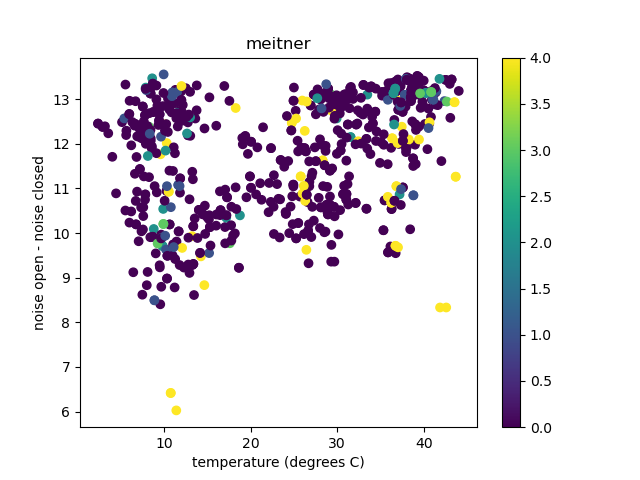

In [10]:
for counter in counters:
    plt.figure()
    plt.scatter([pt[counter][1] for pt in pts if counter in pt], [l[counter] for l in gains if counter in l],c = [int(w[4]) for l,w in zip(gains,weather_codes) if counter in l])
    plt.title(counter)
    plt.xlabel('temperature (degrees C)')
    plt.ylabel('noise open - noise closed')
    plt.colorbar()

/tmp/ipykernel_25811/2361495810.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


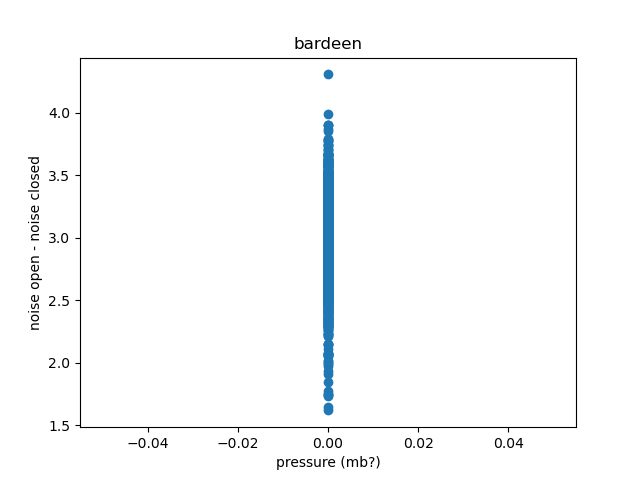

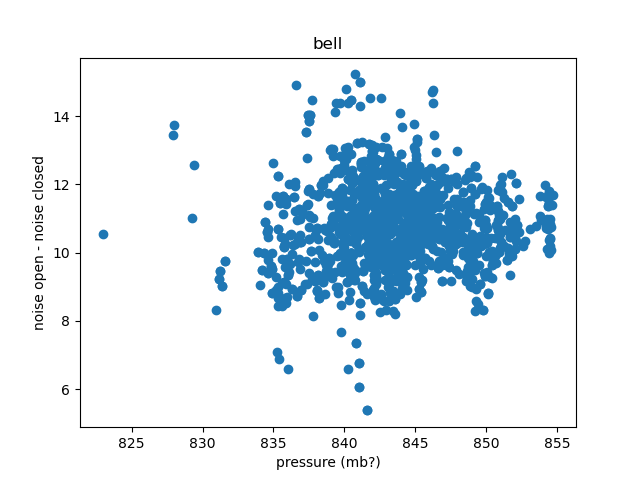

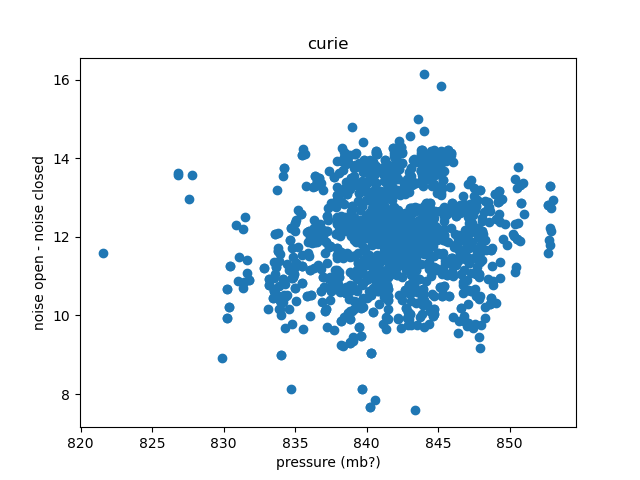

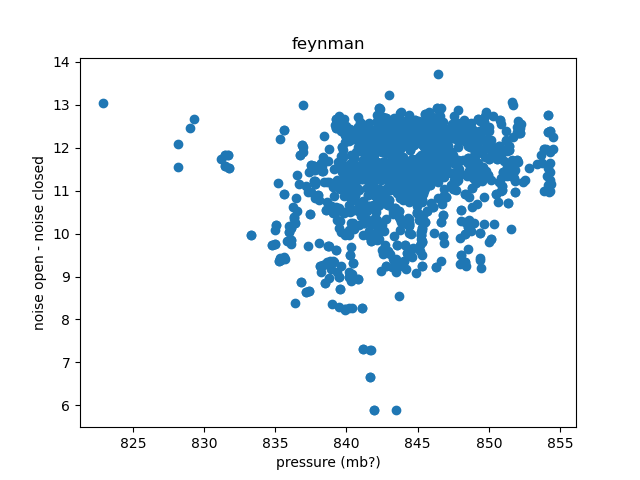

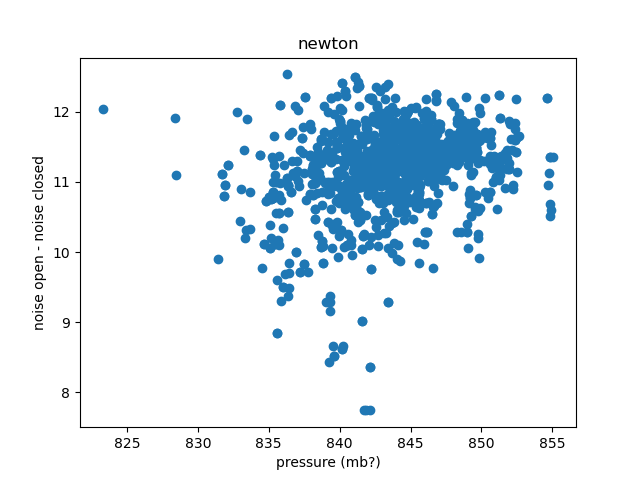

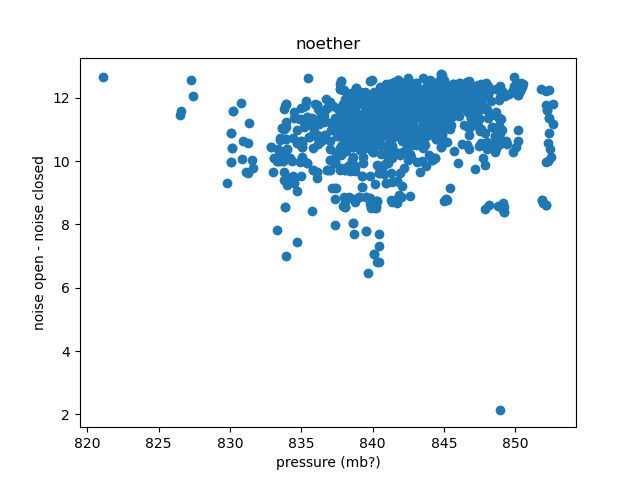

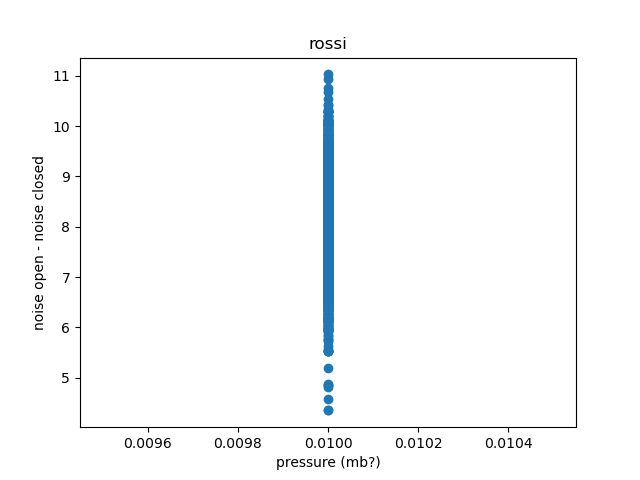

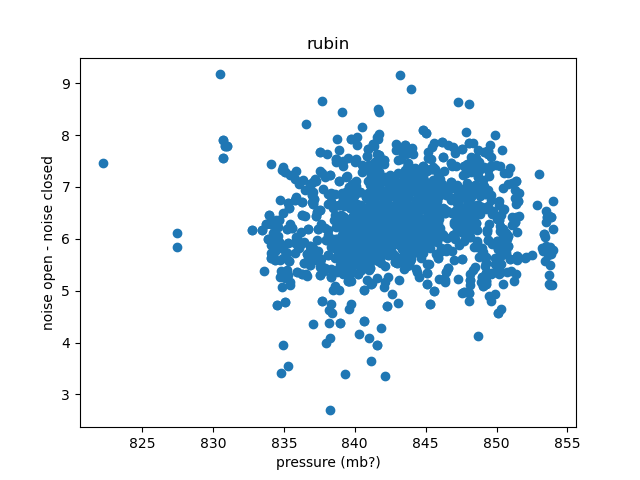

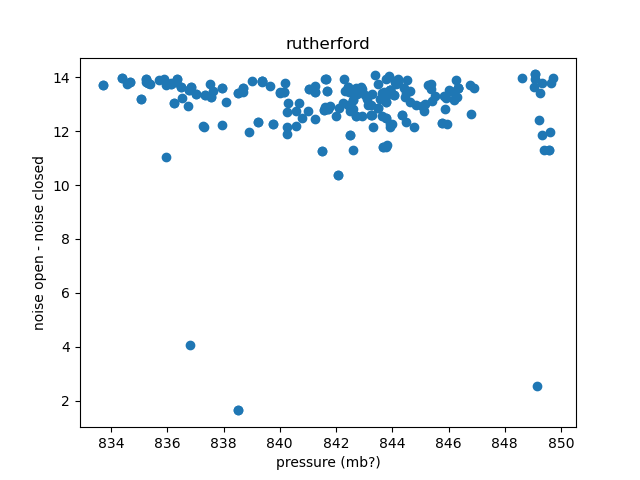

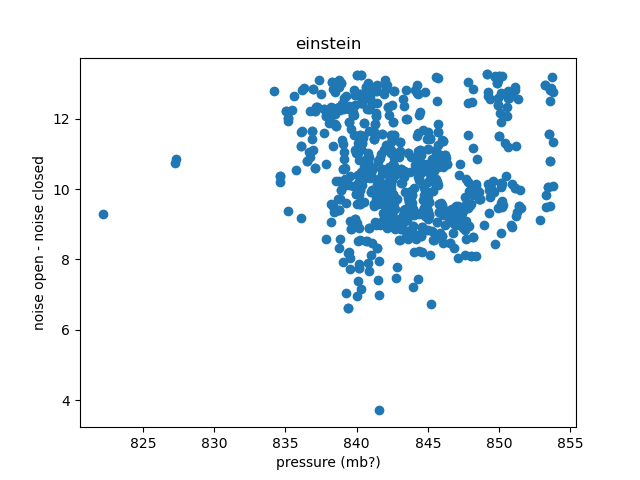

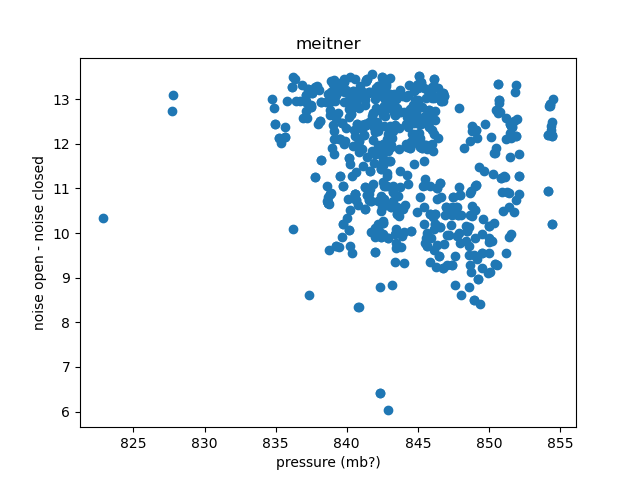

In [12]:
for counter in counters:
    plt.figure()
    plt.scatter([pt[counter][0] for pt in pts if counter in pt], [l[counter] for l in gains if counter in l])
    plt.title(counter)
    plt.xlabel('pressure (mb?)')
    plt.ylabel('noise open - noise closed')

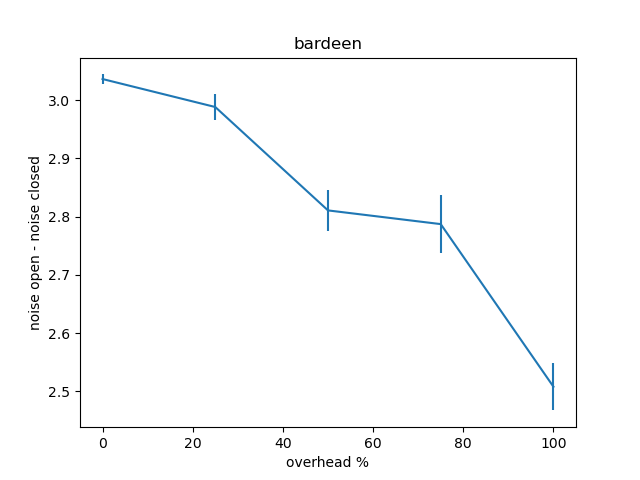

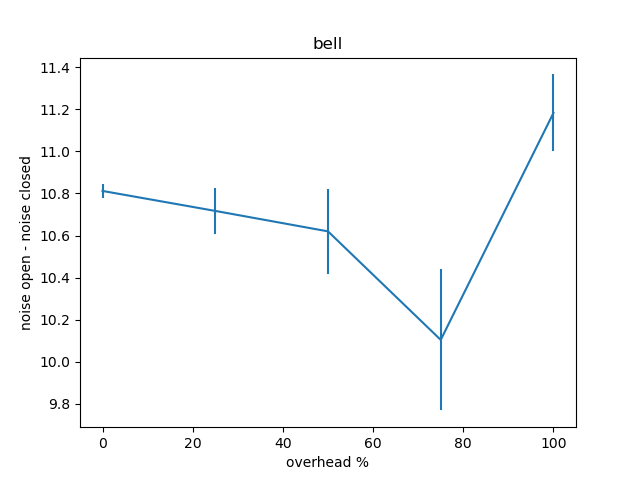

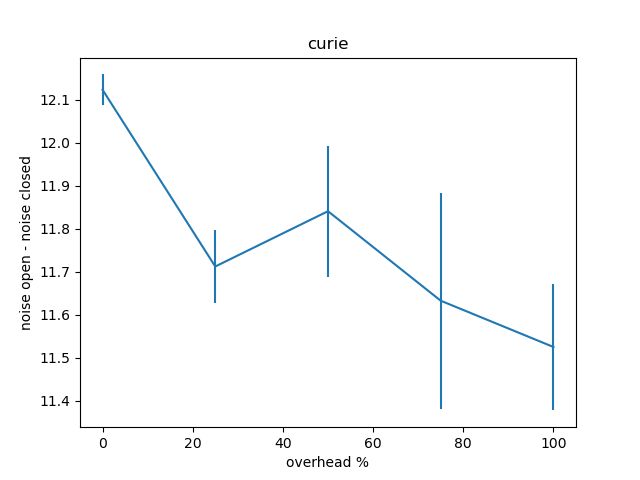

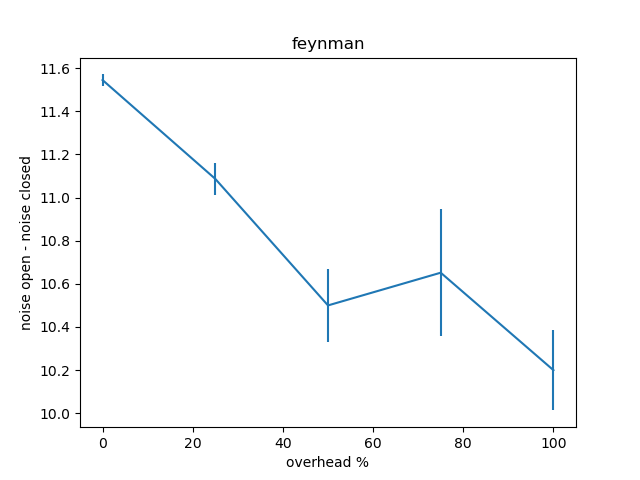

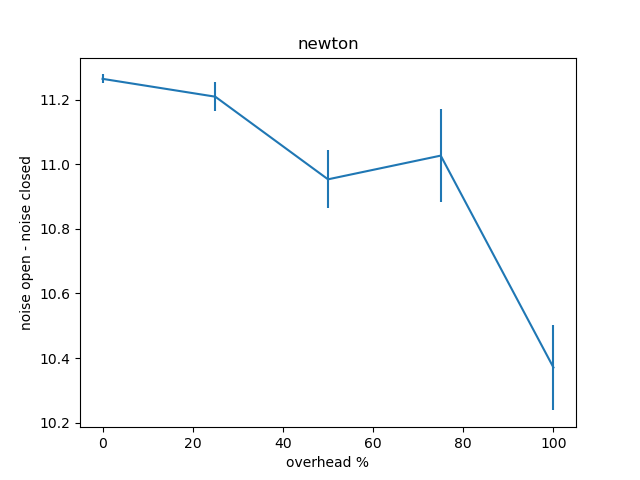

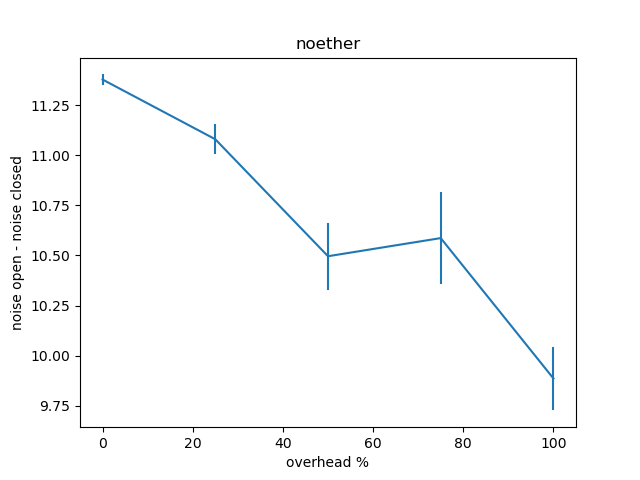

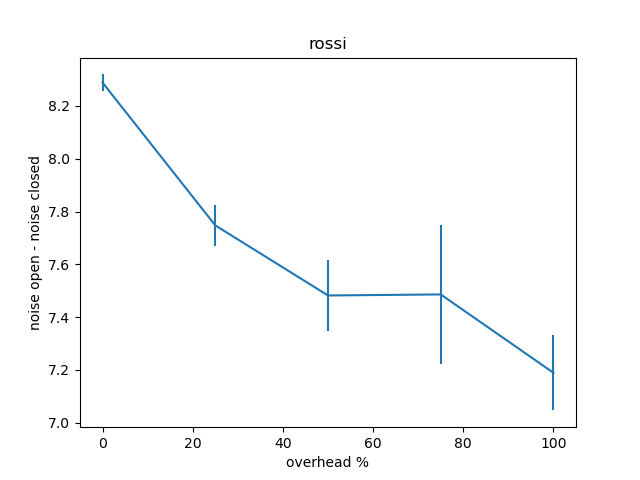

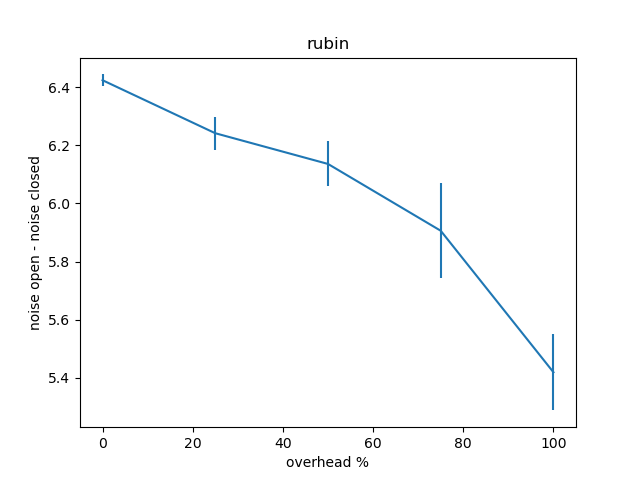

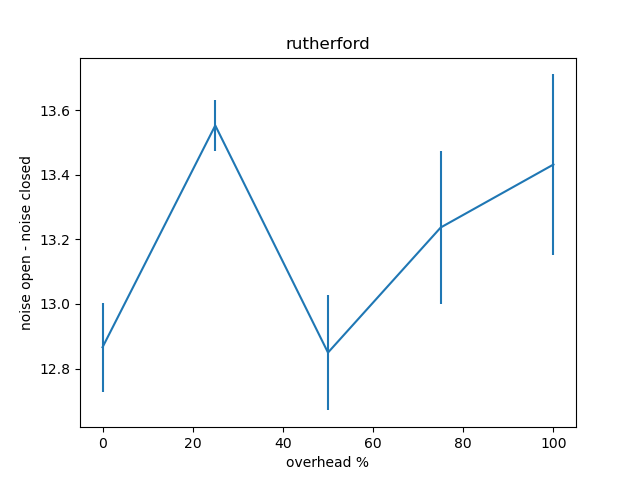

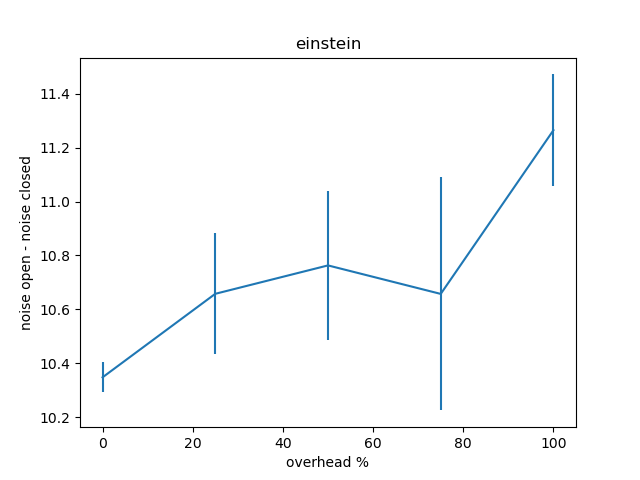

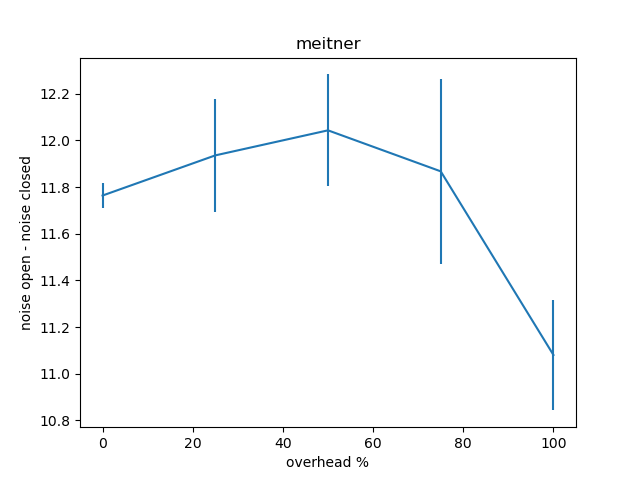

In [13]:
possible_sums = np.arange(0,5,1).astype('float')
for j,counter in enumerate(counters):
    plt.figure()
    wls = [(w,l) for w,l in zip(weather_codes,gains) if counter in l]
    ws = np.array([float(wl[0][4]) for wl in wls])
    ls = np.array([wl[1][counter] for wl in wls])
    l_of_sum = np.empty_like(possible_sums)
    err = np.empty_like(possible_sums)
    for i,s in enumerate(possible_sums):
        levels = ls[ws==s]
        l_of_sum[i] = levels[~np.isnan(levels)].mean()
        err[i] = np.std(levels[~np.isnan(levels)])/np.sqrt(levels[~np.isnan(levels)].size)
    plt.errorbar(possible_sums*25., l_of_sum, yerr=err)
    plt.title(counter)
    plt.xlabel('overhead %')
    plt.ylabel('noise open - noise closed')